Load and Preprocess the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv('synthetic_classification_dataset.csv')

X = df.drop('target', axis=1).values
y = df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (80, 3)
Test set shape: (20, 3)


Define the Neural Network Structure and Backpropagation Implementation

In [2]:
class SimpleDNN:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden1_size) * 0.01
        self.b1 = np.zeros((1, hidden1_size))
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * 0.01
        self.b2 = np.zeros((1, hidden2_size))
        self.W3 = np.random.randn(hidden2_size, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        # Forward propagation
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)
        return self.A3

    def compute_loss(self, y_true, y_pred):
        # Cross-entropy loss
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-10)) / m  # Add small value to avoid log(0)
        return loss

    def backward(self, X, y_true, y_pred):
        m = y_true.shape[0]

        # Output layer
        self.dZ3 = y_pred - y_true
        self.dW3 = np.dot(self.A2.T, self.dZ3) / m
        self.db3 = np.sum(self.dZ3, axis=0, keepdims=True) / m

        # Hidden layer 2
        self.dZ2 = np.dot(self.dZ3, self.W3.T) * self.relu_derivative(self.Z2)
        self.dW2 = np.dot(self.A1.T, self.dZ2) / m
        self.db2 = np.sum(self.dZ2, axis=0, keepdims=True) / m

        # Hidden layer 1
        self.dZ1 = np.dot(self.dZ2, self.W2.T) * self.relu_derivative(self.Z1)
        self.dW1 = np.dot(X.T, self.dZ1) / m
        self.db1 = np.sum(self.dZ1, axis=0, keepdims=True) / m

    def update_weights(self, learning_rate):
        # Update weights and biases
        self.W1 -= learning_rate * self.dW1
        self.b1 -= learning_rate * self.db1
        self.W2 -= learning_rate * self.dW2
        self.b2 -= learning_rate * self.db2
        self.W3 -= learning_rate * self.dW3
        self.b3 -= learning_rate * self.db3


Optimizers Implementation

In [3]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, model):
        model.update_weights(self.learning_rate)

class Adam:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.mW = [np.zeros_like(w) for w in [model.W1, model.W2, model.W3]]
        self.mb = [np.zeros_like(b) for b in [model.b1, model.b2, model.b3]]
        self.t = 0

    def update(self, model):
        self.t += 1
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8

        # Update weights and biases using Adam
        for i, (W, dW, b, db) in enumerate(zip([model.W1, model.W2, model.W3],
                                                [model.dW1, model.dW2, model.dW3],
                                                [model.b1, model.b2, model.b3],
                                                [model.db1, model.db2, model.db3])):
            self.mW[i] = beta1 * self.mW[i] + (1 - beta1) * dW
            self.mb[i] = beta1 * self.mb[i] + (1 - beta1) * db
            mW_hat = self.mW[i] / (1 - beta1 ** self.t)
            mb_hat = self.mb[i] / (1 - beta1 ** self.t)

            W -= self.learning_rate * mW_hat
            b -= self.learning_rate * mb_hat


Train the Model

In [4]:
def train_model(model, X_train, y_train, X_test, y_test, optimizer, epochs=100):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Forward pass
        y_pred = model.forward(X_train)

        # Compute loss
        loss = model.compute_loss(y_train, y_pred)
        train_losses.append(loss)

        # Backward pass
        model.backward(X_train, y_train, y_pred)

        # Update weights
        optimizer.update(model)

        # Evaluate on test set
        test_pred = model.forward(X_test)
        test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
        test_accuracies.append(test_accuracy)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return train_losses, test_accuracies

# Initialize model
input_size = X_train.shape[1]
hidden1_size = 5
hidden2_size = 3
output_size = y_train.shape[1]

# Train with SGD
model = SimpleDNN(input_size, hidden1_size, hidden2_size, output_size)  # Initialize model
sgd_optimizer = SGD(learning_rate=0.01)
train_losses_sgd, test_accuracies_sgd = train_model(model, X_train, y_train, X_test, y_test, sgd_optimizer, epochs=100)

# Train with Adam
model = SimpleDNN(input_size, hidden1_size, hidden2_size, output_size)  # Reset model
adam_optimizer = Adam(learning_rate=0.001)
train_losses_adam, test_accuracies_adam = train_model(model, X_train, y_train, X_test, y_test, adam_optimizer, epochs=100)


Epoch 0/100, Loss: 0.6931, Test Accuracy: 0.6500
Epoch 10/100, Loss: 0.6927, Test Accuracy: 0.6500
Epoch 20/100, Loss: 0.6922, Test Accuracy: 0.6500
Epoch 30/100, Loss: 0.6918, Test Accuracy: 0.6500
Epoch 40/100, Loss: 0.6915, Test Accuracy: 0.6500
Epoch 50/100, Loss: 0.6912, Test Accuracy: 0.6500
Epoch 60/100, Loss: 0.6909, Test Accuracy: 0.6500
Epoch 70/100, Loss: 0.6906, Test Accuracy: 0.6500
Epoch 80/100, Loss: 0.6904, Test Accuracy: 0.6500
Epoch 90/100, Loss: 0.6902, Test Accuracy: 0.6500
Epoch 0/100, Loss: 0.6931, Test Accuracy: 0.6500
Epoch 10/100, Loss: 0.6931, Test Accuracy: 0.6500
Epoch 20/100, Loss: 0.6930, Test Accuracy: 0.6500
Epoch 30/100, Loss: 0.6930, Test Accuracy: 0.6500
Epoch 40/100, Loss: 0.6930, Test Accuracy: 0.6500
Epoch 50/100, Loss: 0.6929, Test Accuracy: 0.6500
Epoch 60/100, Loss: 0.6929, Test Accuracy: 0.6500
Epoch 70/100, Loss: 0.6928, Test Accuracy: 0.6500
Epoch 80/100, Loss: 0.6928, Test Accuracy: 0.6500
Epoch 90/100, Loss: 0.6927, Test Accuracy: 0.6500


Evaluate and Plot Results

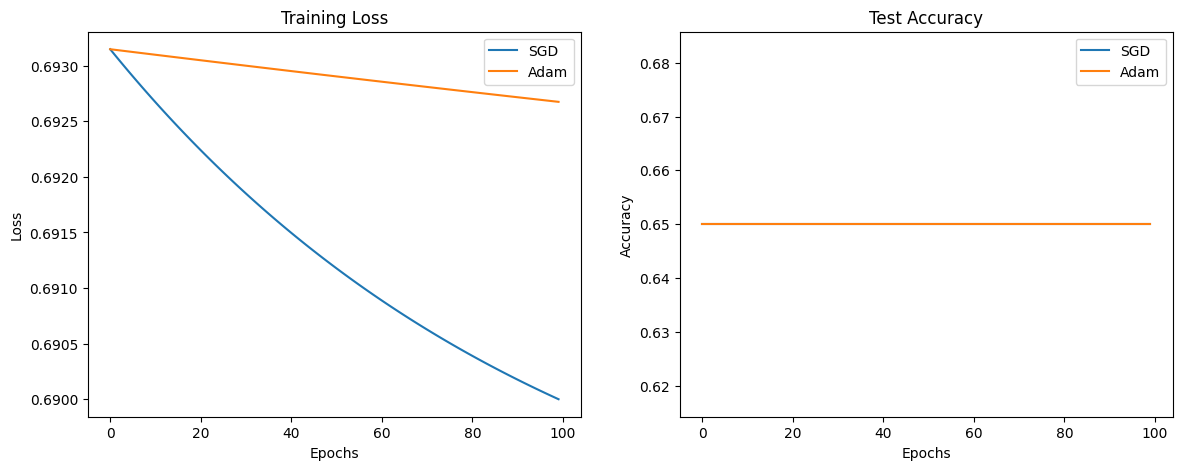

In [5]:
# Plot training loss
plt.figure(figsize=(14, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='SGD')
plt.plot(train_losses_adam, label='Adam')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(test_accuracies_sgd, label='SGD')
plt.plot(test_accuracies_adam, label='Adam')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
